# Analisis de datos

In [364]:
import json
import pandas as pd
from collections import defaultdict
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

In [365]:
# Cargar el archivo JSON
with open("pioneer_challenges.json") as f:
    tournaments = json.load(f)

# Mapeo de colores
color_map = ["white", "blue", "black", "red", "green"]

# Función para codificar los colores en una lista binaria
def encode_colors(colors):
    return ['1' if color in colors else '0' for color in color_map]

data = []

for tournament in tournaments:
    date = tournament["date"]
    positions = []
    color_stats = defaultdict(lambda: {"position_sum": 0, "popularity": 0, "positions": []})

    for position in tournament["positions"]:
        place = int(position["place"].replace("th", "").replace("st", "").replace("nd", "").replace("rd", ""))
        color_encoding = encode_colors(position["colors"])
        color_encoding_tuple = tuple(color_encoding)

        color_stats[color_encoding_tuple]["position_sum"] += place
        color_stats[color_encoding_tuple]["popularity"] += 1
        color_stats[color_encoding_tuple]["positions"].append(place)
        positions.append(place)  # Recolectar todas las posiciones para percentiles

    # Calcular el promedio de posiciones para cada combinación de colores
    for color_encoding, stats in color_stats.items():
        percentiles = [percentileofscore(positions, pos, kind='rank') for pos in stats["positions"]]
        average_position = stats["position_sum"] / stats["popularity"]
        average_percentile = sum(percentiles) / len(percentiles)  # Promedio de percentiles por combinación de colores
        
        data.append({
            "date": date,
            "color_encoding": ''.join(list(color_encoding)),
            "average_position": average_position,
            "average_percentile": average_percentile,
            "popularity": stats["popularity"]
        })

# Convertir los datos a un DataFrame
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])

# Agrupar por día y calcular el promedio diario del percentil
daily_percentiles = df.groupby(["date", "color_encoding"]).agg({
    "average_percentile": "mean",
    "average_position": "mean",
    "popularity": "sum"
}).reset_index()

df = daily_percentiles

In [366]:
print(daily_percentiles)

           date color_encoding  average_percentile  average_position  \
0    2021-01-02          00001           29.687500          8.000000   
1    2021-01-02          00010           42.578125          6.125000   
2    2021-01-02          00011           62.500000          5.000000   
3    2021-01-02          00100           46.354167         11.833333   
4    2021-01-02          00110          100.000000          8.000000   
...         ...            ...                 ...               ...   
6566 2024-10-28          10110           57.812500         18.500000   
6567 2024-10-28          11000           41.666667         13.333333   
6568 2024-10-28          11011           59.375000         19.000000   
6569 2024-10-28          11101           49.218750         15.750000   
6570 2024-10-28          11111           47.656250         15.250000   

      popularity  
0              2  
1              5  
2              2  
3              4  
4              1  
...          ...  
65

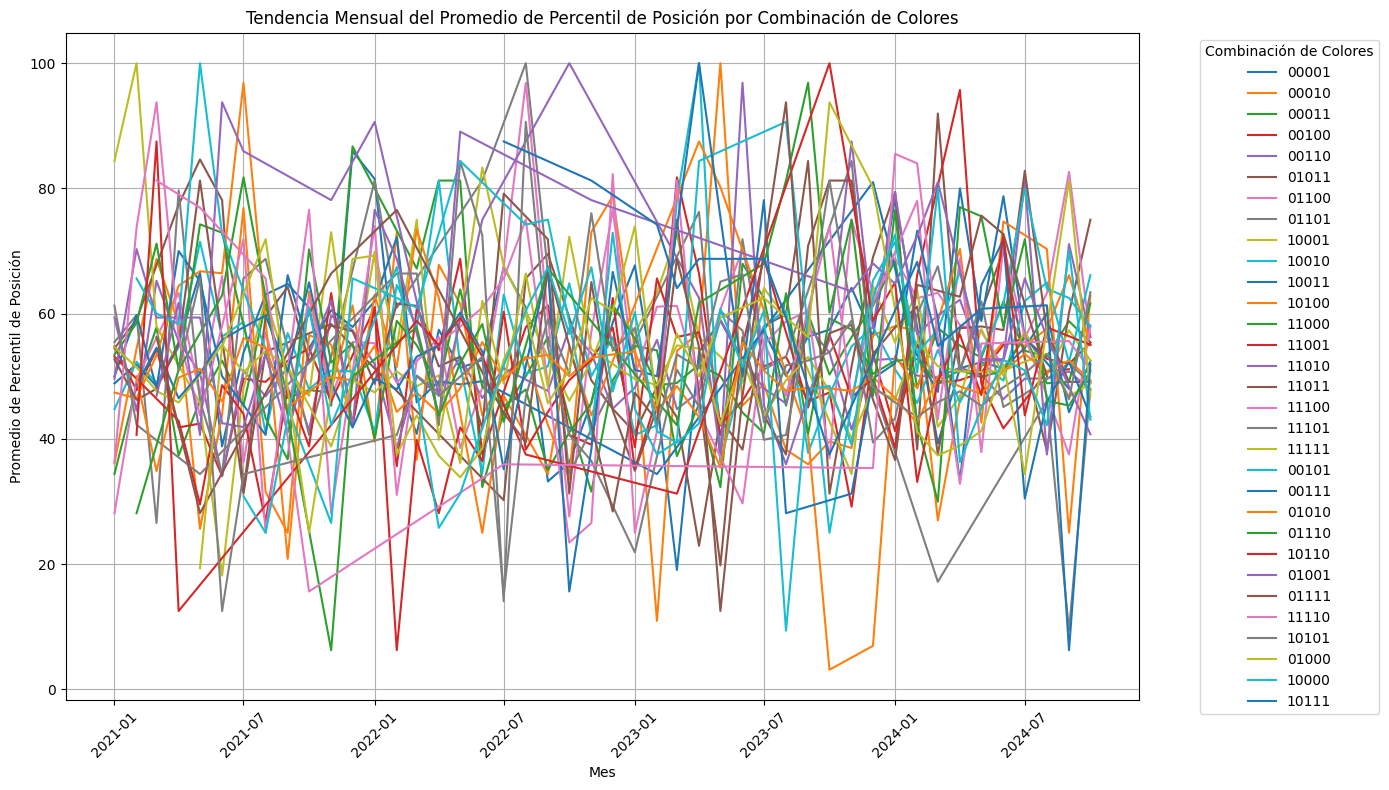

In [367]:
df['date'] = pd.to_datetime(df['date'])

df['month'] = df['date'].dt.to_period('M')

monthly_trend = df.groupby(['month', 'color_encoding']).agg({
    'average_percentile': 'mean'
}).reset_index()

monthly_trend['month'] = monthly_trend['month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
for color_combination in monthly_trend['color_encoding'].unique():
    subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    plt.plot(subset['month'], subset['average_percentile'], label=str(color_combination))

plt.title('Tendencia Mensual del Promedio de Percentil de Posición por Combinación de Colores')
plt.xlabel('Mes')
plt.ylabel('Promedio de Percentil de Posición')
plt.legend(title="Combinación de Colores", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [368]:
unique_color_encodings = monthly_trend['color_encoding'].unique()
print(len(unique_color_encodings))
# for color_combination in unique_color_encodings:
#     subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    
#     # Crear un nuevo gráfico
#     plt.figure(figsize=(10, 6))
#     plt.plot(subset['month'], subset['average_percentile'], marker='o', linestyle='-')
    
#     # Configuración del gráfico
#     plt.title(f'Tendencia Mensual para la Combinación de Colores {color_combination}')
#     plt.xlabel('Mes')
#     plt.ylabel('Promedio de Percentil de Posición')
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
    
#     # Mostrar el gráfico
#     plt.show()

31


In [369]:
df.head(10)

,date,color_encoding,average_percentile,average_position,popularity,month
0,2021-01-02,00001,29.687500,8.000000,2,2021-01
1,2021-01-02,00010,42.578125,6.125000,5,2021-01
2,2021-01-02,00011,62.500000,5.000000,2,2021-01
3,2021-01-02,00100,46.354167,11.833333,4,2021-01
4,2021-01-02,00110,100.000000,8.000000,1,2021-01
5,2021-01-02,01011,57.291667,18.333333,3,2021-01
6,2021-01-02,01101,64.062500,20.500000,4,2021-01
7,2021-01-02,10010,59.375000,8.500000,4,2021-01
8,2021-01-02,10100,59.375000,19.000000,5,2021-01
9,2021-01-02,11001,43.750000,14.000000,1,2021-01


In [370]:
df.tail(10)

,date,color_encoding,average_percentile,average_position,popularity,month
6561,2024-10-28,01100,12.500000,4.000000,2,2024-10
6562,2024-10-28,01110,40.625000,13.000000,2,2024-10
6563,2024-10-28,10000,100.000000,32.000000,2,2024-10
6564,2024-10-28,10001,60.156250,19.250000,8,2024-10
6565,2024-10-28,10100,12.500000,4.000000,2,2024-10
6566,2024-10-28,10110,57.812500,18.500000,4,2024-10
6567,2024-10-28,11000,41.666667,13.333333,6,2024-10
6568,2024-10-28,11011,59.375000,19.000000,2,2024-10
6569,2024-10-28,11101,49.218750,15.750000,8,2024-10
6570,2024-10-28,11111,47.656250,15.250000,6,2024-10


# Normalizacion y preparacion

In [371]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Agrupacion por mes

In [372]:
monthly_df = df.groupby(['month', 'color_encoding']).apply(
    lambda x: pd.Series({
        'average_percentile_monthly': np.sum(x['average_percentile'] * x['popularity']) / np.sum(x['popularity']),
        'average_popularity_monthly': np.mean(x['popularity'])
    })
).reset_index()

In [373]:
monthly_df.head(10)

,month,color_encoding,average_percentile_monthly,average_popularity_monthly
0,2021-01,00001,47.694672,6.100000
1,2021-01,00010,32.756696,3.500000
2,2021-01,00011,43.750000,1.500000
3,2021-01,00100,40.487939,3.800000
4,2021-01,00110,59.375000,1.000000
5,2021-01,01011,54.939516,3.444444
6,2021-01,01100,38.541667,3.000000
7,2021-01,01101,56.180556,4.500000
8,2021-01,10001,84.375000,1.000000
9,2021-01,10010,53.188776,4.900000


## Rellenado de datos

In [374]:
all_months = monthly_df['month'].unique()
all_color_encodings = monthly_df['color_encoding'].unique()
all_combinations = pd.MultiIndex.from_product([all_months, all_color_encodings], names=['month', 'color_encoding']).to_frame(index=False)

all_combinations.head()

,month,color_encoding
0,2021-01,00001
1,2021-01,00010
2,2021-01,00011
3,2021-01,00100
4,2021-01,00110


In [375]:
monthly_df_complete = all_combinations.merge(monthly_df, on=['month', 'color_encoding'], how='left')
first_appearance = monthly_df_complete[monthly_df_complete['average_percentile_monthly'].notna()].groupby('color_encoding')['month'].min()

In [376]:
def interpolate_from_first_appearance(df, column):
    for color_encoding, start_month in first_appearance.items():
        mask = (df['color_encoding'] == color_encoding) & (df['month'] >= start_month)
        df.loc[mask, column] = df.loc[mask, column].interpolate(method='linear', limit_direction='both')
    return df

In [377]:
monthly_df_complete = interpolate_from_first_appearance(monthly_df_complete, 'average_percentile_monthly')
monthly_df_complete['average_popularity_monthly'].fillna(0, inplace=True)

for color_encoding, start_month in first_appearance.items():
    mask = (monthly_df_complete['color_encoding'] == color_encoding) & (monthly_df_complete['month'] < start_month)
    monthly_df_complete.loc[mask, 'average_percentile_monthly'] = None

monthly_df_complete.dropna(subset=['average_percentile_monthly'], inplace=True)
monthly_df_complete.reset_index(drop=True, inplace=True)


In [378]:
monthly_df_complete.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly
0,2021-01,00001,47.694672,6.1
1,2021-01,00010,32.756696,3.5
2,2021-01,00011,43.750000,1.5
3,2021-01,00100,40.487939,3.8
4,2021-01,00110,59.375000,1.0


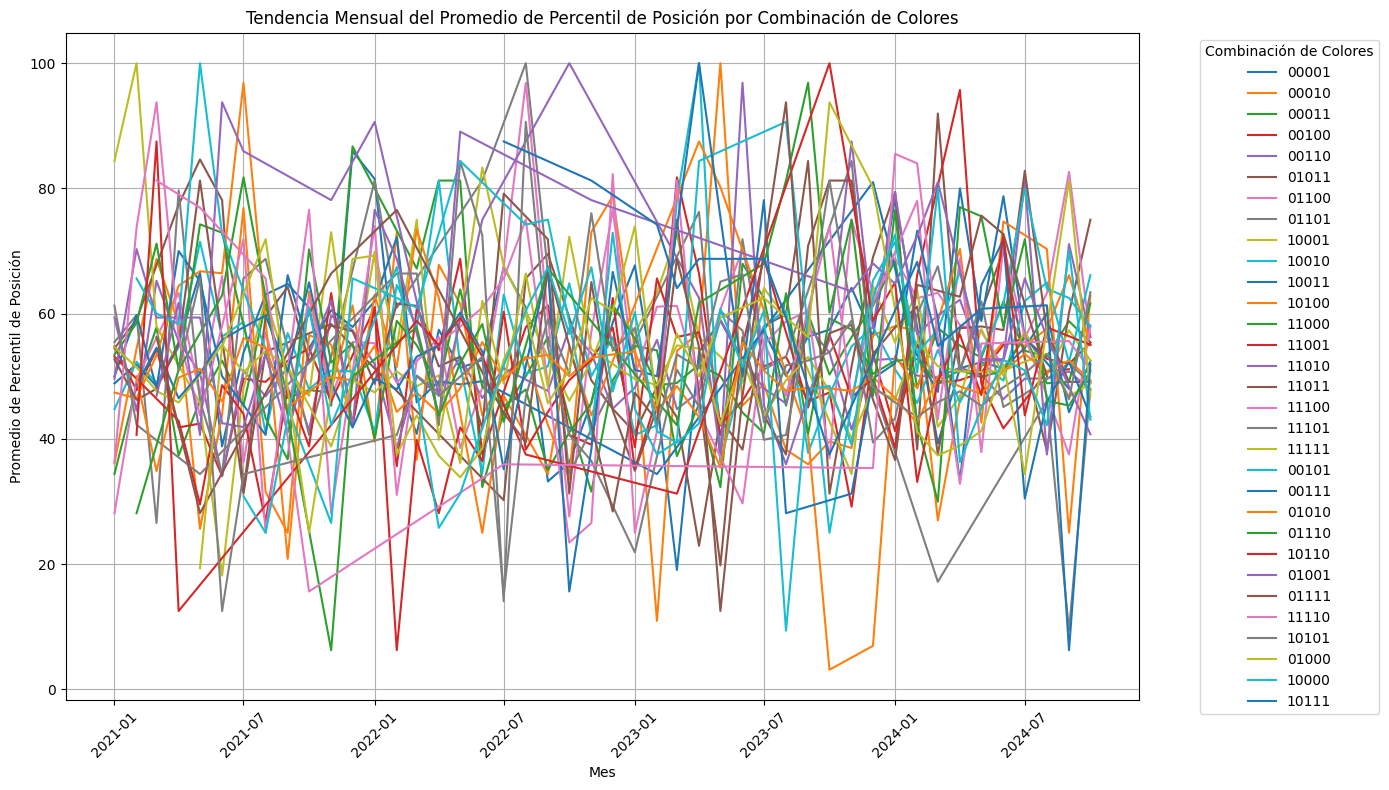

In [379]:
plt.figure(figsize=(14, 8))
for color_combination in monthly_df_complete['color_encoding'].unique():
    subset = monthly_trend[monthly_trend['color_encoding'] == color_combination]
    plt.plot(subset['month'], subset['average_percentile'], label=str(color_combination))

plt.title('Tendencia Mensual del Promedio de Percentil de Posición por Combinación de Colores')
plt.xlabel('Mes')
plt.ylabel('Promedio de Percentil de Posición')
plt.legend(title="Combinación de Colores", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [380]:
# for color_combination in unique_color_encodings:
#     subset = monthly_df_complete[monthly_df_complete['color_encoding'] == color_combination]
#     subset['month'] = subset['month'].dt.to_timestamp()
    
#     # Crear un nuevo gráfico
#     plt.figure(figsize=(10, 6))
#     plt.plot(subset['month'], subset['average_percentile_monthly'], marker='o', linestyle='-')
    
#     # Configuración del gráfico
#     plt.title(f'Tendencia Mensual para la Combinación de Colores {color_combination}')
#     plt.xlabel('Mes')
#     plt.ylabel('Promedio de Percentil de Posición')
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
    
#     # Mostrar el gráfico
#     plt.show()

## Normalizacion

In [381]:
scaler_percentile = MinMaxScaler()
monthly_df_complete['average_percentile_monthly_norm'] = scaler_percentile.fit_transform(monthly_df_complete[['average_percentile_monthly']])
monthly_df_complete['popularity_monthly_norm'] = np.log1p(monthly_df_complete['average_popularity_monthly'])
monthly_df_complete['color_encoding_norm'] = monthly_df_complete['color_encoding'].apply(lambda x: int(x, 2) / 31) 

In [382]:
monthly_df_complete.head()

,month,color_encoding,average_percentile_monthly,average_popularity_monthly,average_percentile_monthly_norm,popularity_monthly_norm,color_encoding_norm
0,2021-01,00001,47.694672,6.1,0.460074,1.960095,0.032258
1,2021-01,00010,32.756696,3.5,0.305876,1.504077,0.064516
2,2021-01,00011,43.750000,1.5,0.419355,0.916291,0.096774
3,2021-01,00100,40.487939,3.8,0.385682,1.568616,0.129032
4,2021-01,00110,59.375000,1.0,0.580645,0.693147,0.193548


## Preparacion de secuencias

In [383]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [384]:
monthly_df_complete['month_num'] = monthly_df_complete['month'].apply(lambda x: (x.year - monthly_df_complete['month'].min().year) * 12 + x.month)

In [385]:
cutoff_date = pd.Timestamp(year=pd.Timestamp.today().year, month=3, day=1)
train_data = monthly_df_complete[monthly_df_complete['month'].dt.to_timestamp() < cutoff_date]
val_data = monthly_df_complete[monthly_df_complete['month'].dt.to_timestamp() >= cutoff_date]

In [386]:
print(f"Train size: {train_data.shape[0]}, Val size: {val_data.shape[0]}, Split: {(val_data.shape[0]/train_data.shape[0])*100}%")

Train size: 1136, Val size: 248, Split: 21.830985915492956%


In [387]:
global_sequence_length = 1
global_features = ['color_encoding_norm', 'average_percentile_monthly_norm', 'popularity_monthly_norm']
target = 'average_percentile_monthly_norm'

In [388]:
full_train_gen = TimeseriesGenerator(
    train_data[global_features].values, train_data[target].values,
    length=global_sequence_length, batch_size=1
)

In [389]:
full_val_gen = TimeseriesGenerator(
    val_data[global_features].values, val_data[target].values,
    length=global_sequence_length, batch_size=1
)

In [390]:
train_timeseries_for_color = {}
val_timeseries_for_color = {}
specific_sequence_length = 6
specific_features = ['average_percentile_monthly_norm', 'popularity_monthly_norm']

for color_combination in monthly_df_complete['color_encoding'].unique():
    subset_train = train_data[train_data['color_encoding'] == color_combination]
    train_data_gen = TimeseriesGenerator(
        subset_train[specific_features].values, subset_train[target].values,
        length=specific_sequence_length, batch_size=1
    )
    train_timeseries_for_color[color_combination] = train_data_gen
    
    subset_val = val_data[val_data['color_encoding'] == color_combination]
    val_data_gen = TimeseriesGenerator(
        subset_val[specific_features].values, subset_val[target].values,
        length=specific_sequence_length, batch_size=1
    )
    val_timeseries_for_color[color_combination] = val_data_gen

In [391]:
len(train_timeseries_for_color)

31

In [392]:
len(val_timeseries_for_color)

31

## Datos para Capa Densa

In [393]:
X_train = train_data[['month_num', 'color_encoding_norm', 'popularity_monthly_norm']].values
y_train = train_data['average_percentile_monthly_norm'].values

In [394]:
X_val = val_data[['month_num', 'color_encoding_norm', 'popularity_monthly_norm']].values
y_val = val_data['average_percentile_monthly_norm'].values


# Modelos

In [395]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense


## Modelo de Capa Densa -> Considera todos los datos

In [396]:
modelDense = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

modelDense.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Modelo LSTM global -> toma en cuenta todas las combinaciones de colores

In [397]:
modelGlobalLSTM = Sequential([
    Input(shape=(global_sequence_length, len(global_features))),
    LSTM(50, activation='relu'),
    Dense(1)
])

modelGlobalLSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Modelos LSTM Especificos -> Toman en cuenta unicamente el historial de una combinacion de colores

In [398]:
models_for_color = {}

epochs = 50
batch_size = 1

for color_combination, train_gen in train_timeseries_for_color.items():
    modelLSTM = Sequential([
        Input(shape=(specific_sequence_length, len(specific_features))),
        LSTM(50, activation='relu'),
        Dense(1)
    ])

    modelLSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    models_for_color[color_combination] = modelLSTM

# 1er Entrenamiento

## Modelo Denso

In [399]:
from tensorflow.keras.callbacks import EarlyStopping

In [400]:
history = modelDense.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9595 - mae: 1.3315 - val_loss: 0.0854 - val_mae: 0.2640
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.0417 - mae: 0.1635 - val_loss: 0.0711 - val_mae: 0.2378
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0349 - mae: 0.1466 - val_loss: 0.0343 - val_mae: 0.1572
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.0343 - mae: 0.1455 - val_loss: 0.0225 - val_mae: 0.1181
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.0298 - mae: 0.1327 - val_loss: 0.0160 - val_mae: 0.0891
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.0316 - mae: 0.1378 - val_loss: 0.0375 - val_mae: 0.1647
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.0256 - mae: 0.1202 - val_loss: 0.0566 - val_mae: 0.2107
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0289 - mae: 0.1308 - val_loss: 0.0170 - val_mae: 0.0939
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss

### Grafico

In [401]:
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
# plt.plot(history.history['val_loss'], label='Pérdida de validación')
# plt.xlabel('Épocas')
# plt.ylabel('Pérdida (MSE)')
# plt.title('Pérdida durante el entrenamiento')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='MAE de entrenamiento')
# plt.plot(history.history['val_mae'], label='MAE de validación')
# plt.xlabel('Épocas')
# plt.ylabel('MAE')
# plt.title('Error Absoluto Medio durante el entrenamiento')
# plt.legend()

# plt.tight_layout()
# plt.show()

## Modelo LSTM Global

In [402]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = modelGlobalLSTM.fit(
    full_train_gen,
    validation_data=full_val_gen,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 0.0712 - mae: 0.1993 - val_loss: 0.0167 - val_mae: 0.0930
Epoch 2/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - loss: 0.0275 - mae: 0.1264 - val_loss: 0.0157 - val_mae: 0.0856
Epoch 3/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.0281 - mae: 0.1296 - val_loss: 0.0174 - val_mae: 0.0969
Epoch 4/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step - loss: 0.0282 - mae: 0.1289 - val_loss: 0.0181 - val_mae: 0.1006
Epoch 5/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - loss: 0.0266 - mae: 0.1243 - val_loss: 0.0158 - val_mae: 0.0849
Epoch 6/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - loss: 0.0281 - mae: 0.1262 - val_loss: 0.0155 - val_mae: 0.0870
Epoch 7/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - loss: 0.0275 - mae: 0.1283 - val_loss: 0.0163 - val_mae: 0.0915
Epoch 8/50
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.0281 - mae: 0.1298 - val_loss: 0.0169 - val_mae: 0.0906
Epoch 9/50
1135/1135 ━━━━━━━━━━━━━━

### Grafico

In [403]:
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
# plt.plot(history.history['val_loss'], label='Pérdida de validación')
# plt.xlabel('Épocas')
# plt.ylabel('Pérdida (MSE)')
# plt.title('Pérdida durante el entrenamiento')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='MAE de entrenamiento')
# plt.plot(history.history['val_mae'], label='MAE de validación')
# plt.xlabel('Épocas')
# plt.ylabel('MAE')
# plt.title('Error Absoluto Medio durante el entrenamiento')
# plt.legend()

# plt.tight_layout()
# plt.show()

## Modelos LSTM Especificos

In [404]:
history_for_color = {}
for color_combination, train_gen in train_timeseries_for_color.items():
    val_gen = val_timeseries_for_color[color_combination]
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = models_for_color[color_combination].fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )
    history_for_color[color_combination] = history

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2069 - mae: 0.4260 - val_loss: 0.0133 - val_mae: 0.1152
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0238 - mae: 0.1132 - val_loss: 0.0087 - val_mae: 0.0934
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - mae: 0.0958 - val_loss: 0.0153 - val_mae: 0.1238
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0199 - mae: 0.1008 - val_loss: 0.0072 - val_mae: 0.0848
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mae: 0.1139 - val_loss: 6.8298e-04 - val_mae: 0.0258
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - mae: 0.0971 - val_loss: 0.0107 - val_mae: 0.1036
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - mae: 0.0844 - val_loss: 0.0028 - val_mae: 0.0523
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - mae: 0.0967 - val_loss: 0.0013 - val_mae: 0.0364
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - m

### Graficos

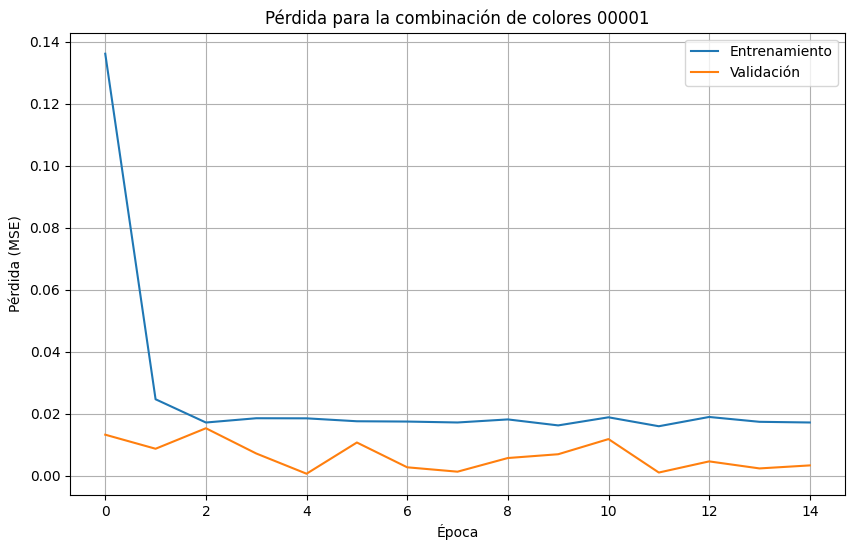

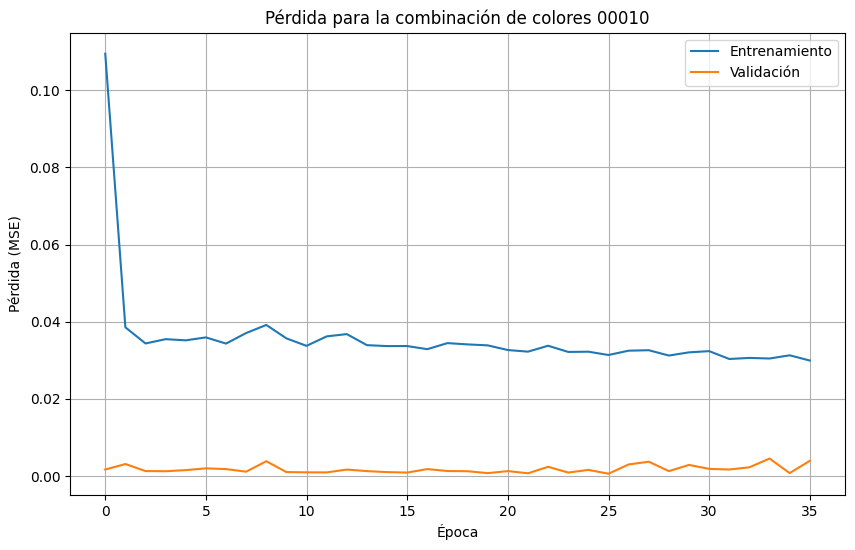

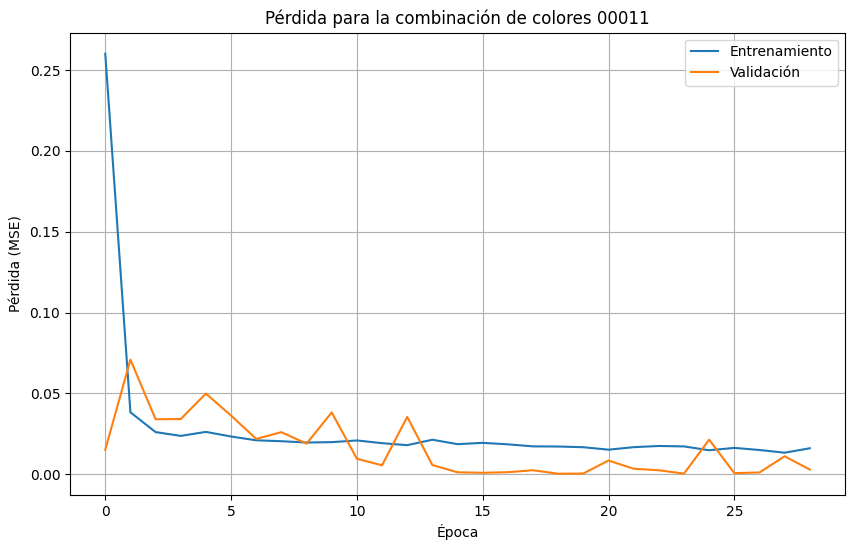

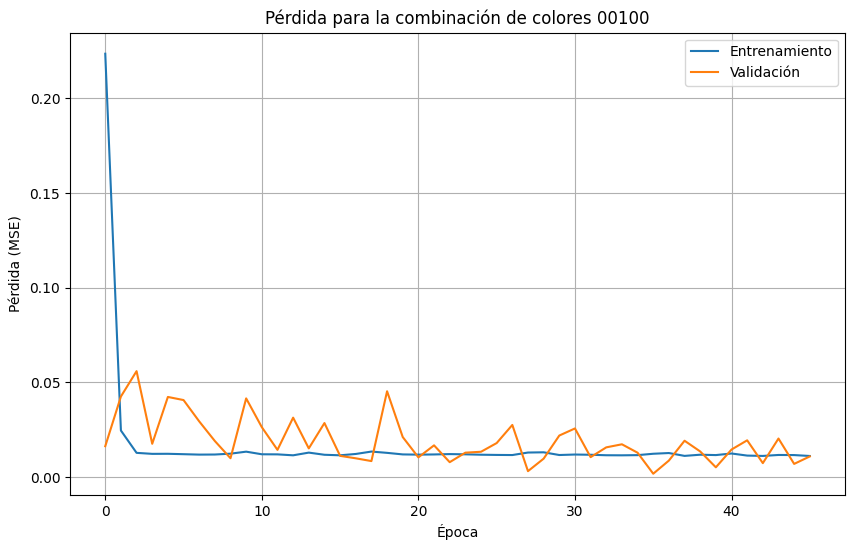

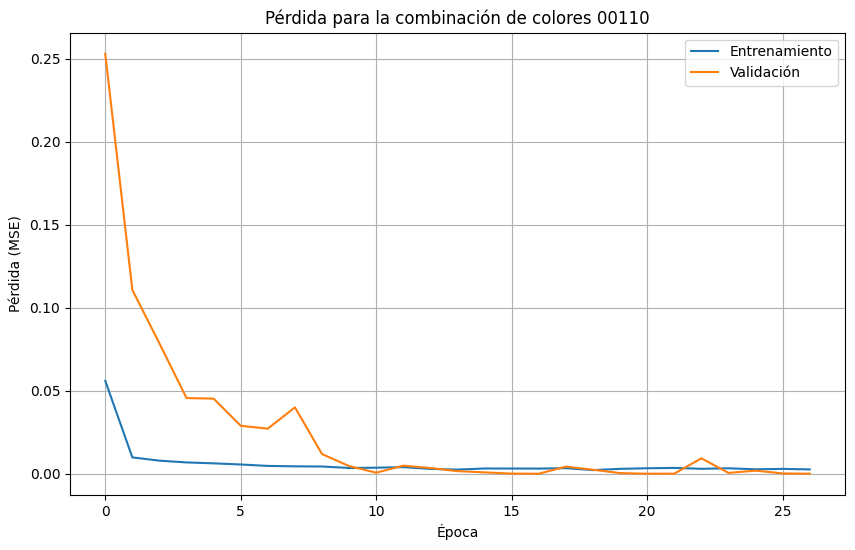

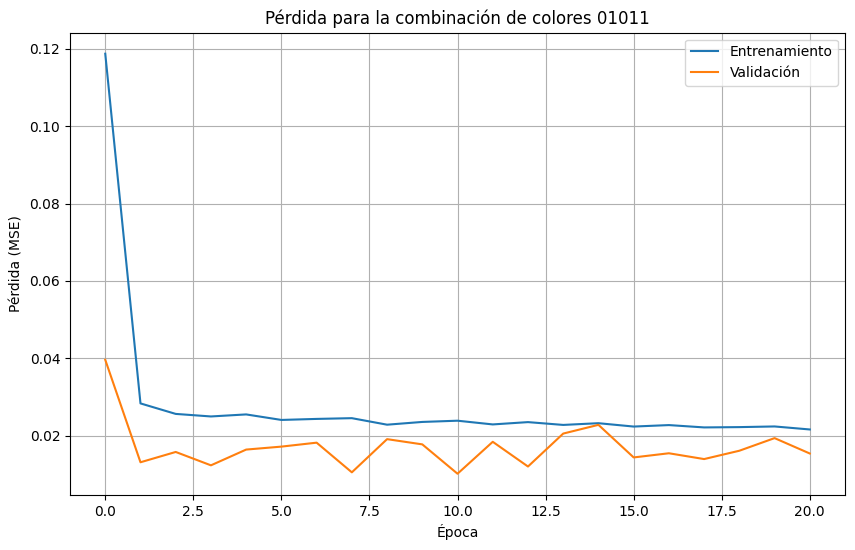

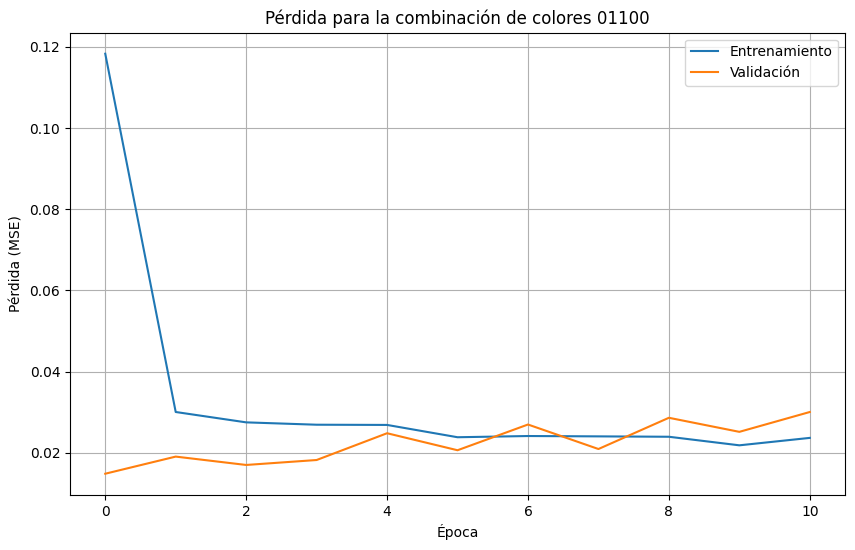

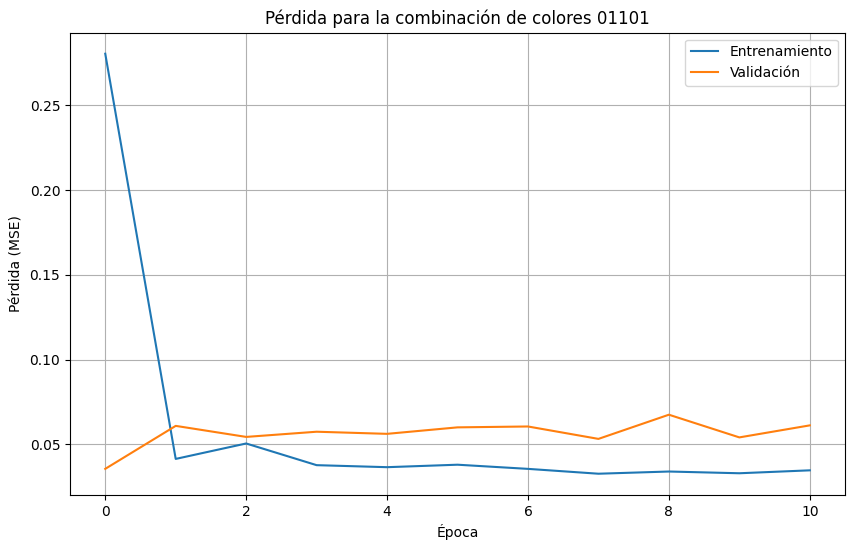

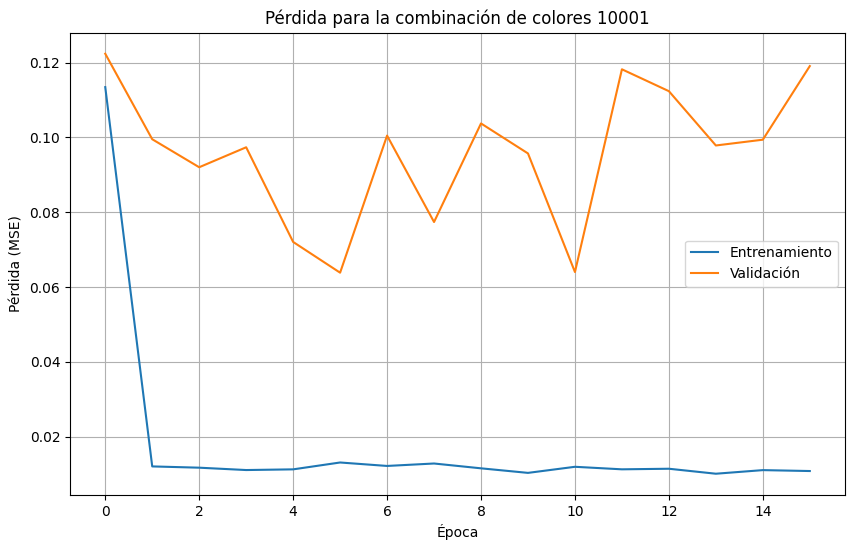

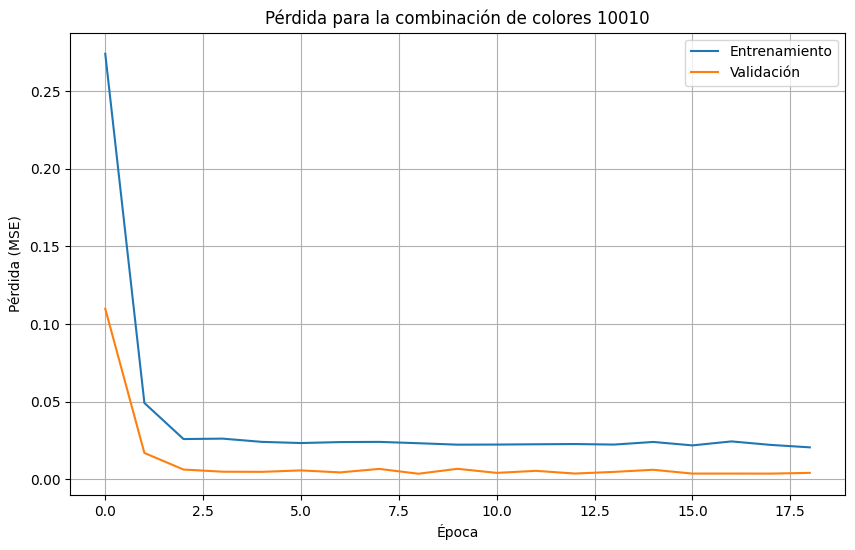

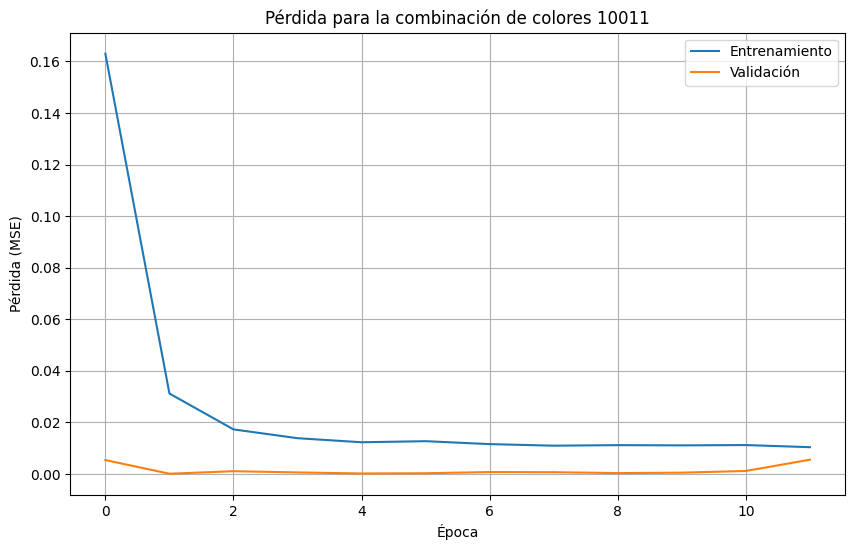

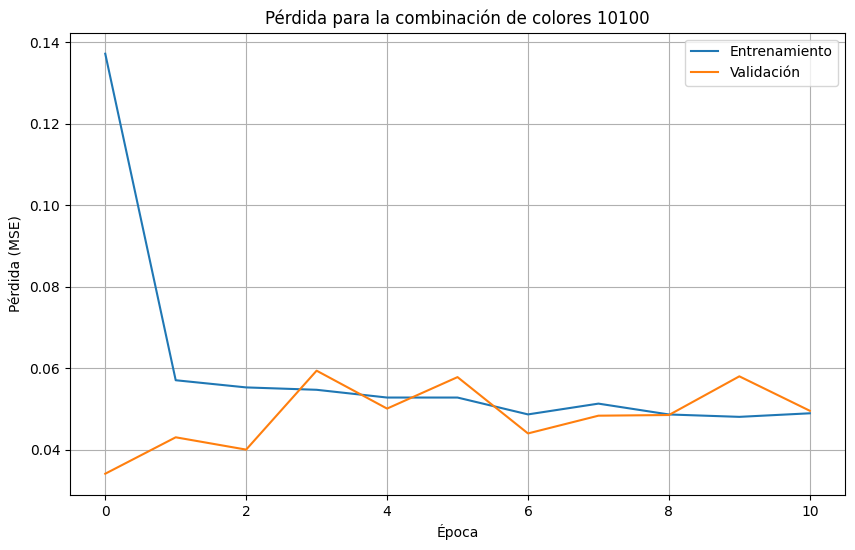

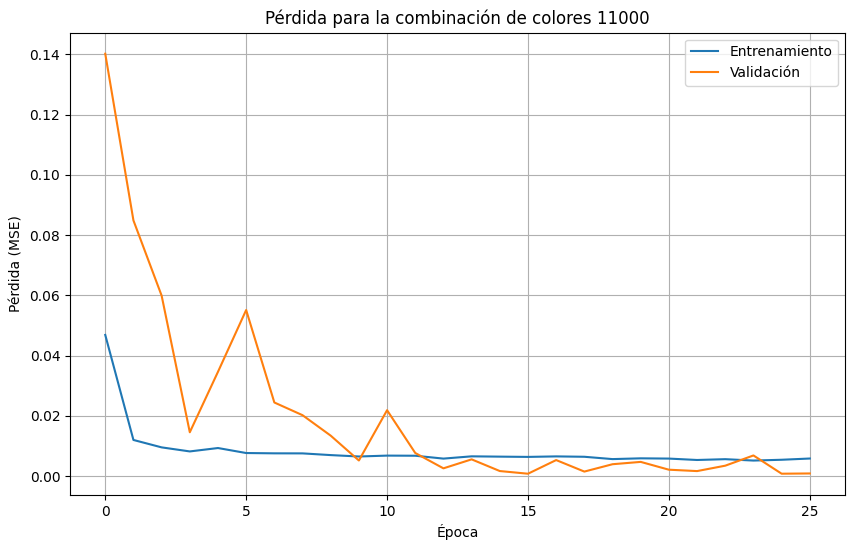

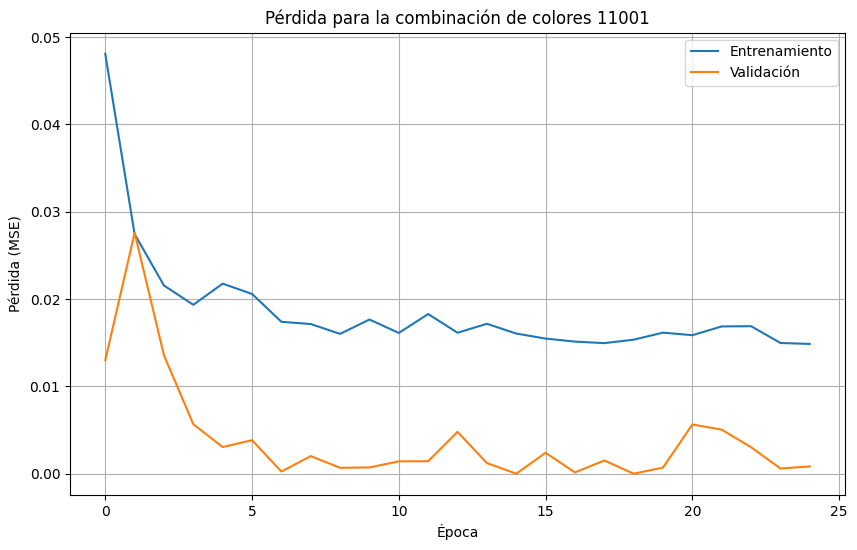

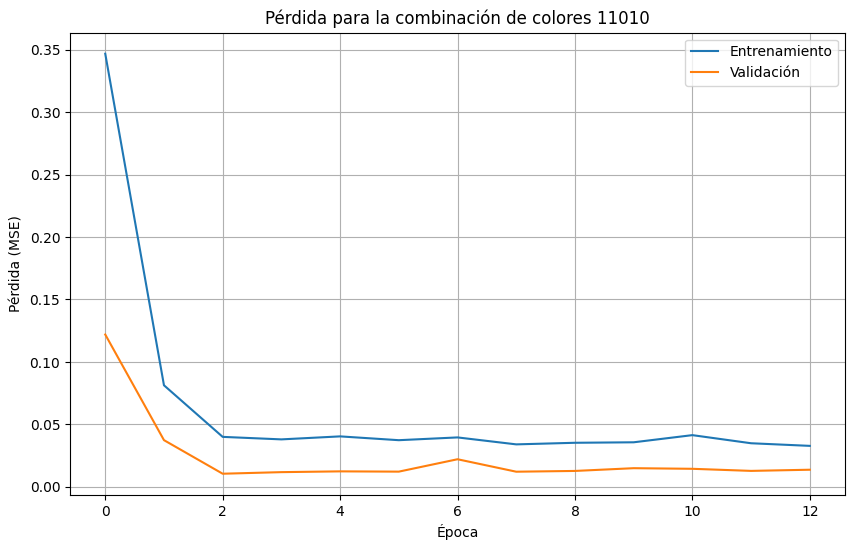

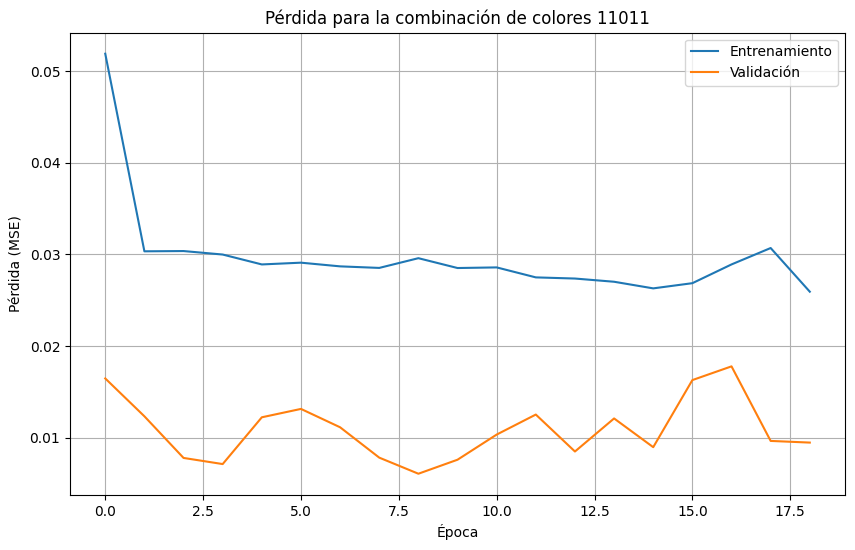

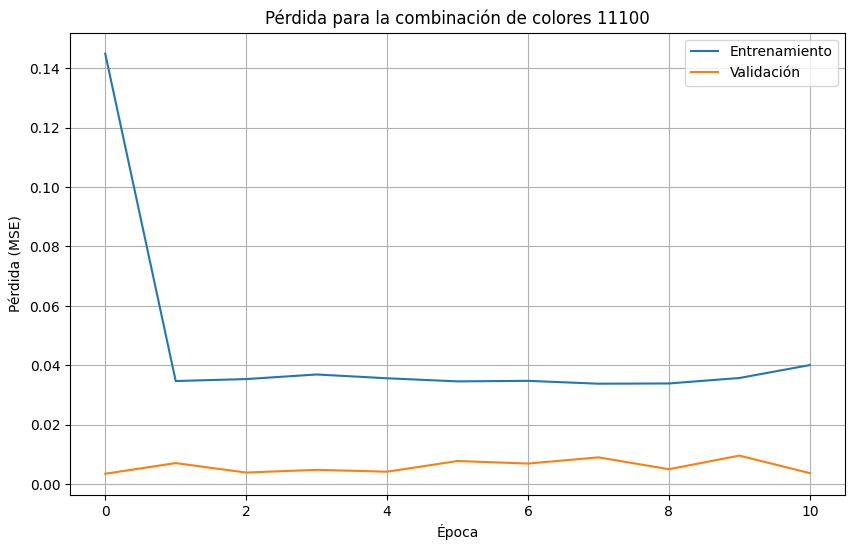

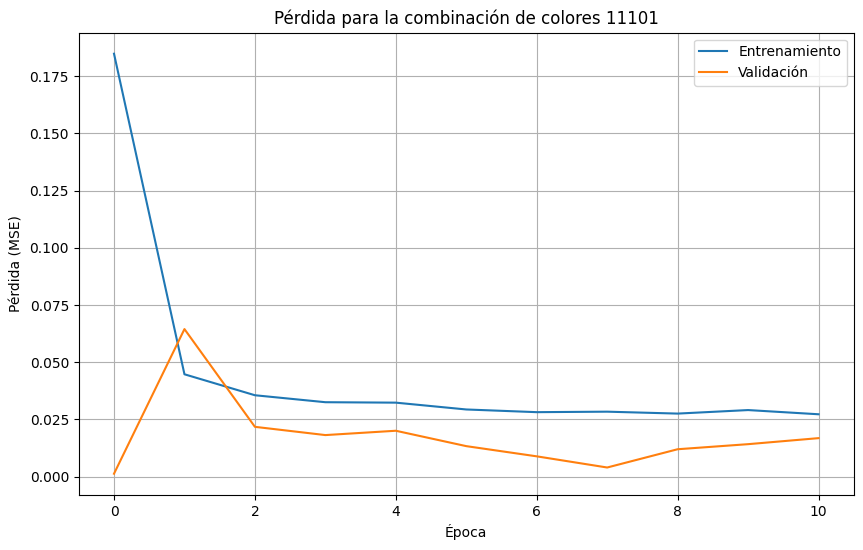

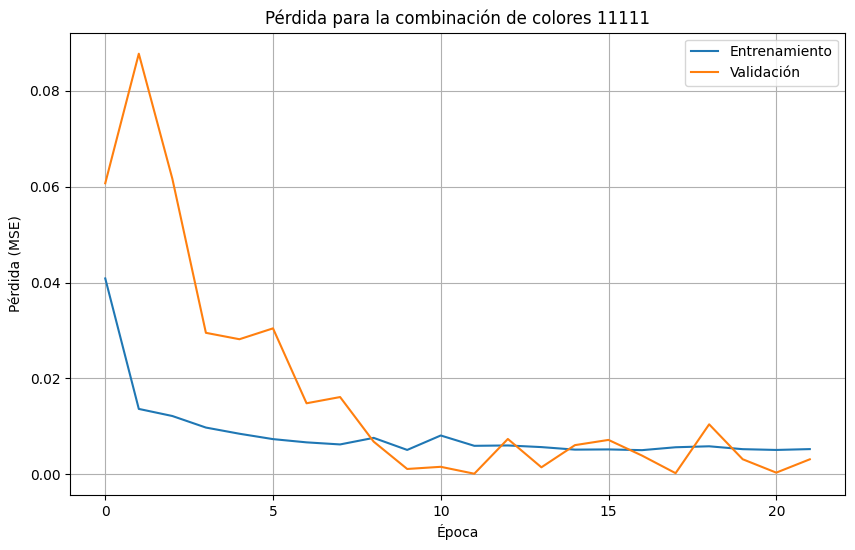

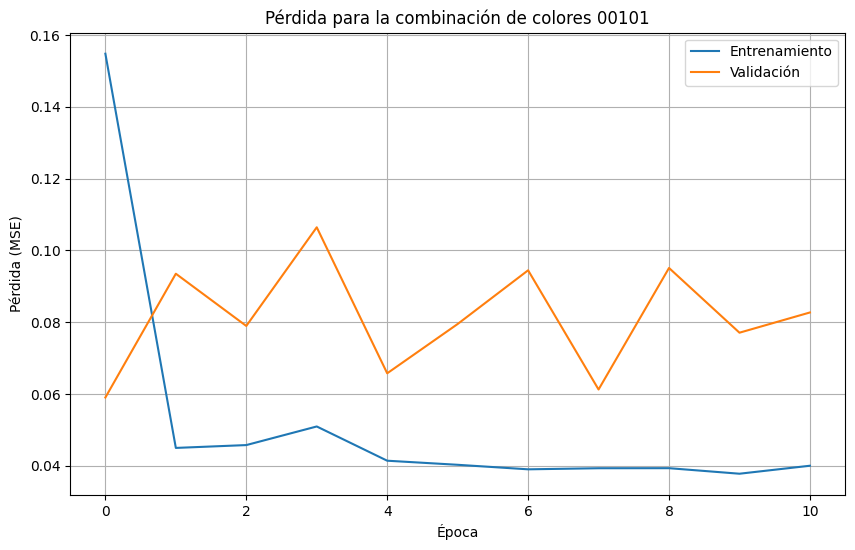

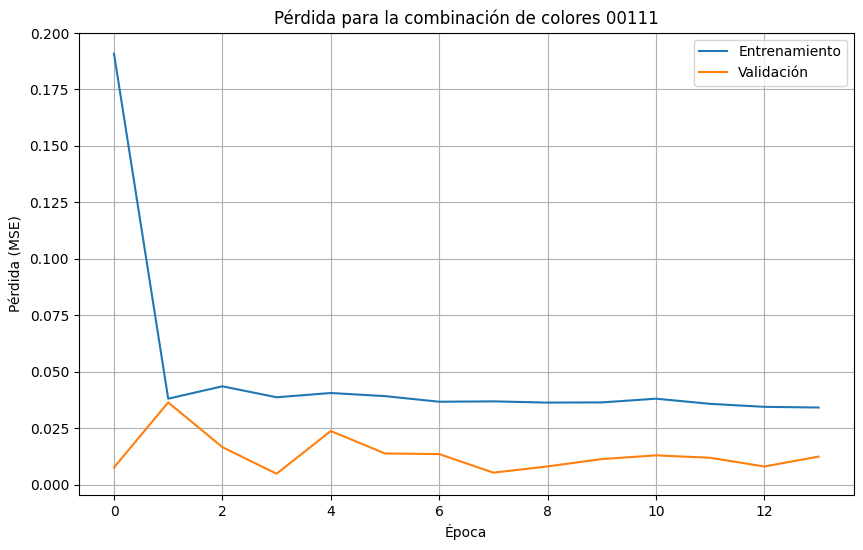

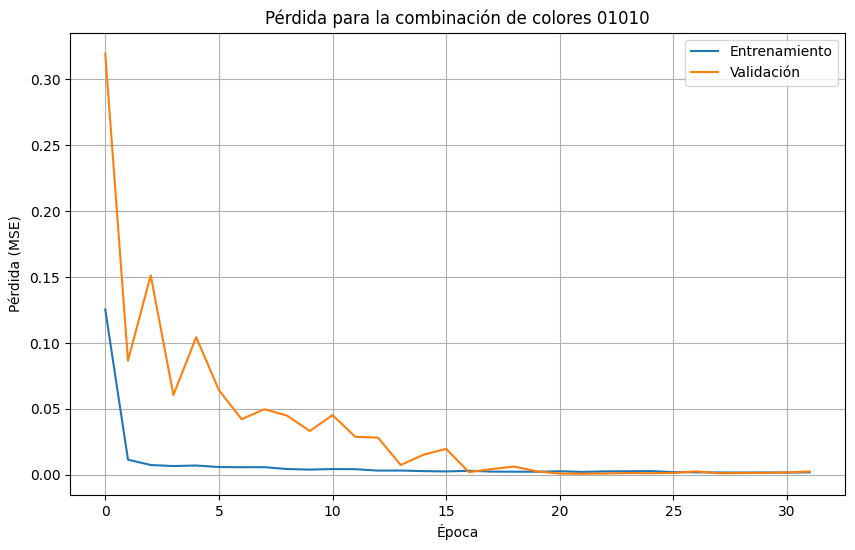

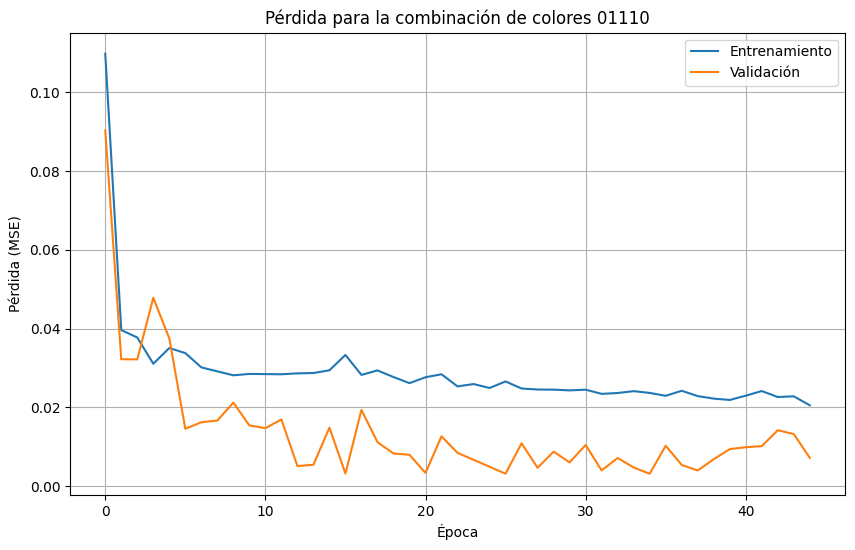

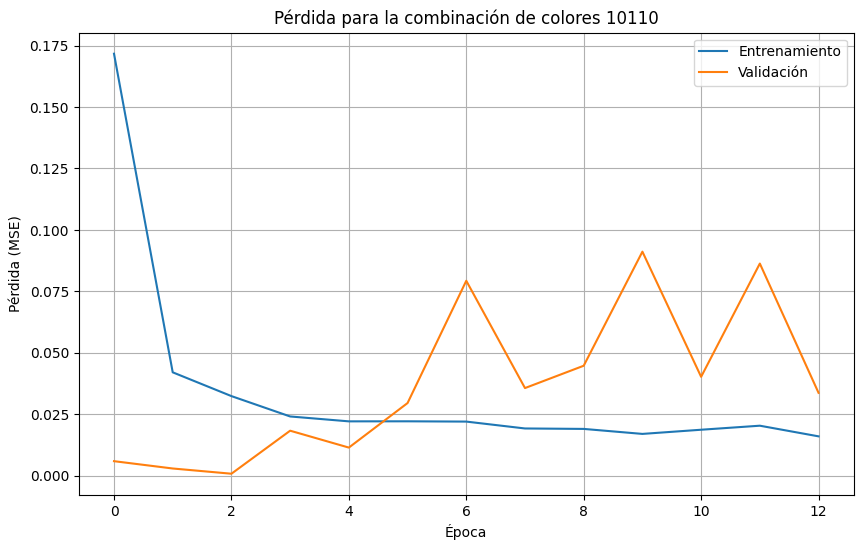

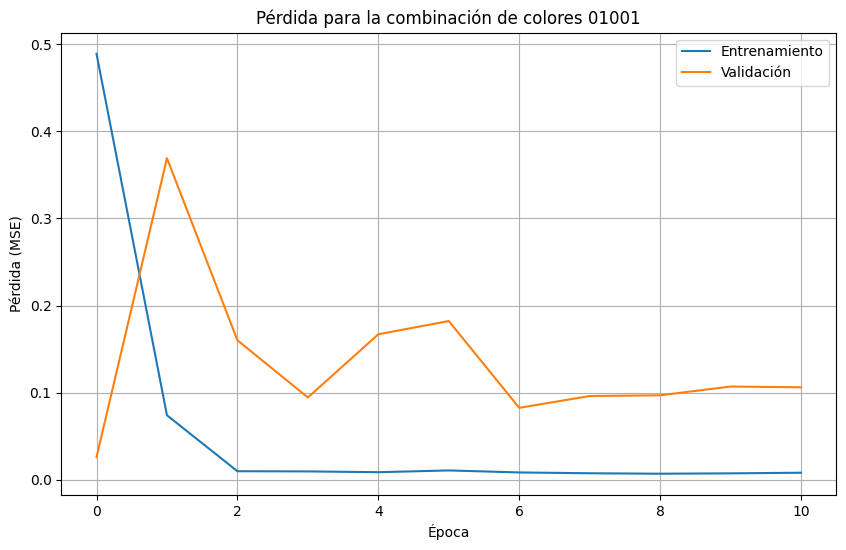

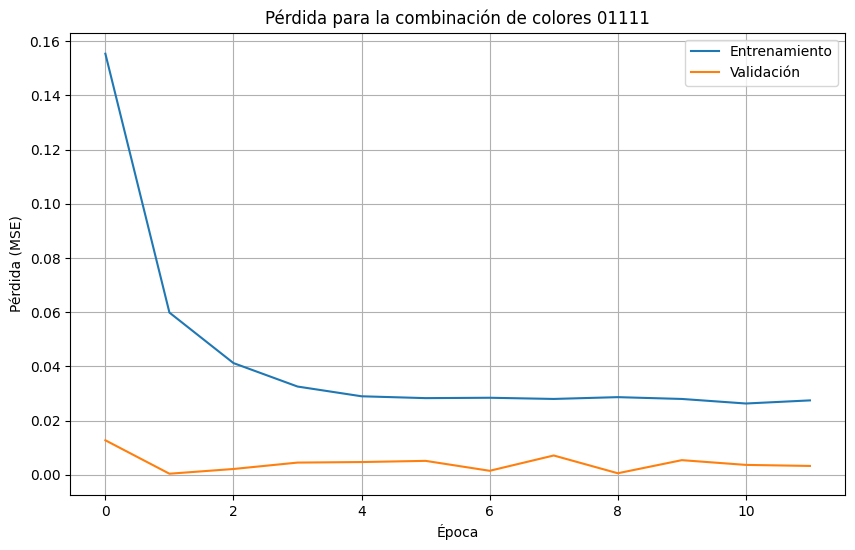

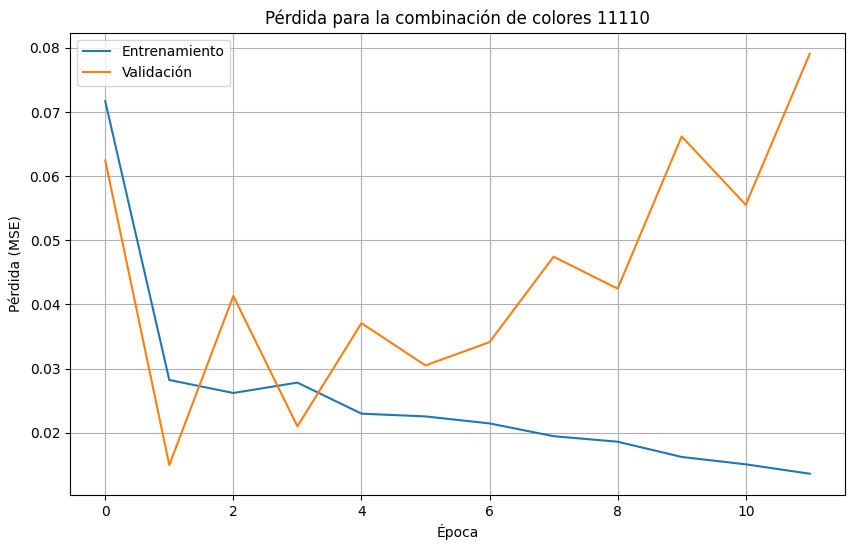

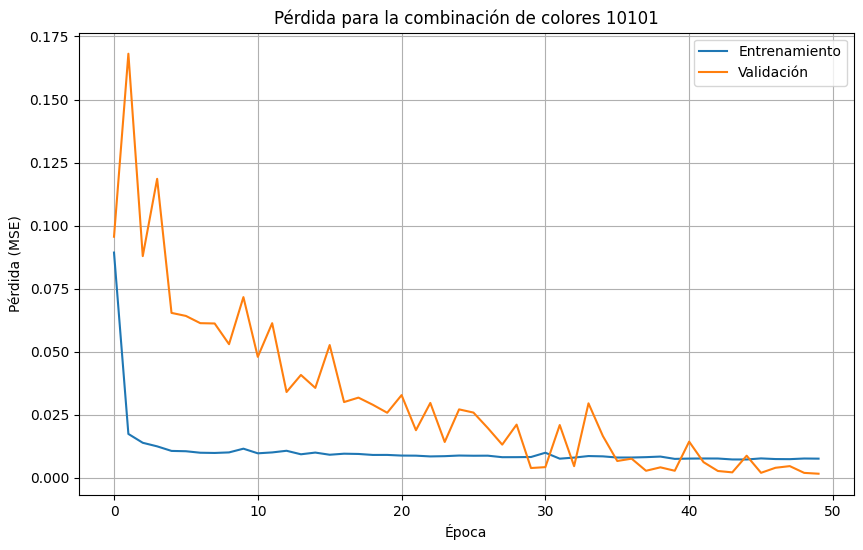

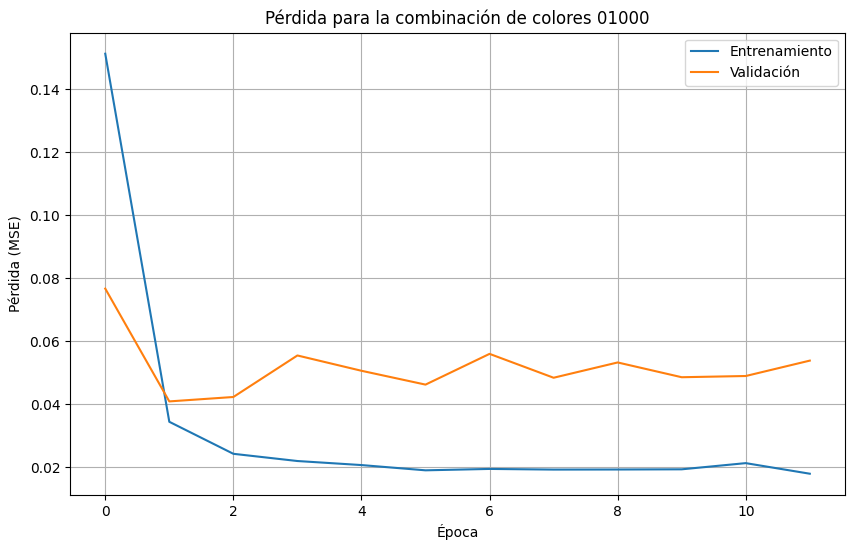

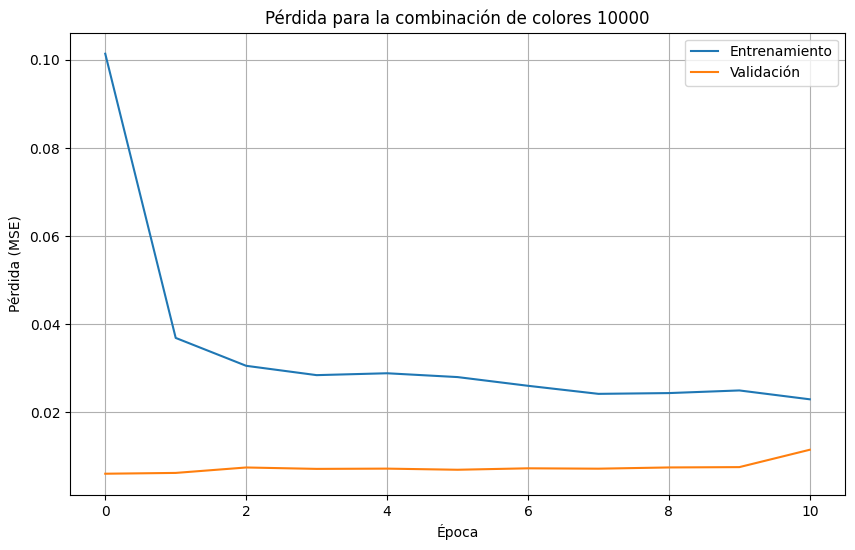

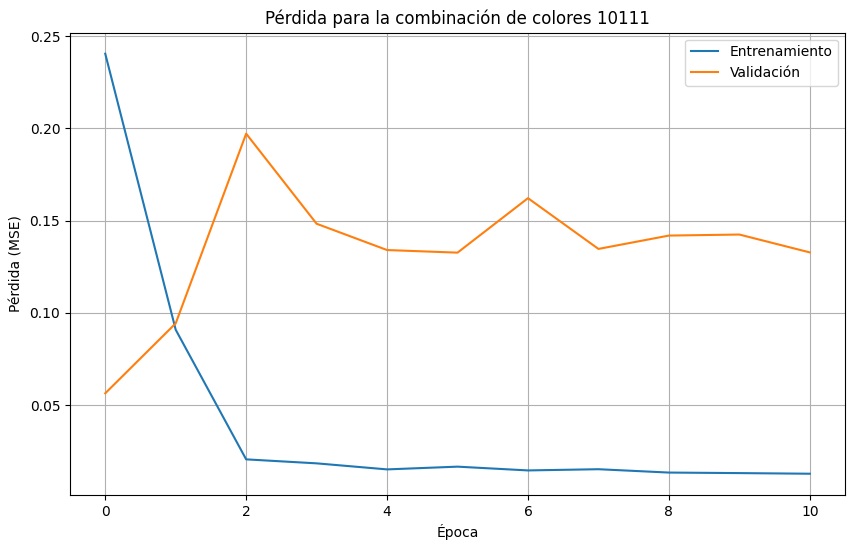

In [405]:
for color_combination, history in history_for_color.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida para la combinación de colores {color_combination}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Unificacion de datos

In [406]:
denso_pred_train = np.array(modelDense.predict(X_train)).flatten()
denso_pred_val = np.array(modelDense.predict(X_val)).flatten()

print(denso_pred_train.shape)

denso_predictions_train = pd.DataFrame({
    "month": train_data["month"],
    "color_encoding": train_data["color_encoding"],
    "denso_pred_train": denso_pred_train,
})

denso_predictions_val = pd.DataFrame({
    "month": val_data["month"],
    "color_encoding": val_data["color_encoding"],
    "denso_pred_val": denso_pred_val,
})

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
(1136,)


In [407]:
full_train_gen

In [408]:
globalLSTM_pred_train = np.array(modelGlobalLSTM.predict(full_train_gen)).flatten()
globalLSTM_pred_val = np.array(modelGlobalLSTM.predict(full_val_gen)).flatten()

print(globalLSTM_pred_train.shape)

globalLSTM_predictions_train = pd.DataFrame({
    "month": train_data["month"],
    "color_encoding": train_data["color_encoding"],
    "denso_pred_train": globalLSTM_pred_train,
})

globalLSTM_predictions_val = pd.DataFrame({
    "month": val_data["month"],
    "color_encoding": val_data["color_encoding"],
    "denso_pred_val": globalLSTM_pred_val,
})

1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
(1135,)


ValueError: array length 1135 does not match index length 1136

# Prediccion

In [ ]:
# def predict(color_comb, popularity_values, max_popularity, max_position):
#     color_comb = encode_colors(color_comb)
#     color_encoding_norm = int(''.join(color_comb),2)/31
#     sequence_length = 6  

#     popularity_values_normalized = (np.array(popularity_values) - 1) / (max_popularity - 1)

#     input_sequences = []
#     for popularity in popularity_values_normalized:
#         sequence = [[color_encoding_norm, 0, popularity]] * sequence_length
#         input_sequences.append(sequence)

#     input_sequences = np.array(input_sequences)
    
#     predictions = model.predict(input_sequences)

#     predictions_denormalized = predictions * (max_position - 1) + 1
    
#     for pop, pred in zip(popularity_values, predictions_denormalized):
#         print(f"Popularidad: {pop}, Predicción de posición promedio: {pred[0]:.2f}")
    
#     return predictions_denormalized

In [ ]:
# max_popularity = 20
# max_position = 20

# color_comb = ['blue', 'red']
# popularity_values = [1,5,10,15,20]

In [ ]:
# predictions_denormalized = predict(color_comb=color_comb, popularity_values=popularity_values, max_popularity=max_popularity, max_position=max_position)